<a href="https://colab.research.google.com/github/monicafar147/unsupervised-predict-streamlit-template/blob/modelling/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDSA Movie Recommendation Challenge

This notebook was created to enter the private kaggle competition of EDSA on creating a movie recommendation predictor.

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis.

One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

This notebook will construct a recommendation algorithm based on content and collaborative filtering in order to accurately predict how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase generating revenue and platform affinity.

# Table of Contents

1. Imports
    - 1.1. Launching Comet Experiment
    - 1.2. Importing modules
    - 1.3. Import datasets
2. Confirmatory Data Analysis
    - 2.1. Data Info
    - 2.2. Missing Values
3. Exploratory Data Analysis
    - 3.1 What is the highest rated movie?
    - 3.2 Which genre has the highest release of movies?
    - 3.3 Who is the most frequent actor?
    - 3.4 Top directors
    - 3.5 Popular keywords in movie data
    - 3.6 How is the target label distributed?
4. Modelling
    - 4.1 Collaborative based prediction
    - 4.2 Content based prediction 
5. Performance evaluation
    - 5.1 Recommender comparison
6. Comet version control

# Imports

## Launching Comet Experiment

In [3]:
#pip install comet_ml


The following command must be run outside of the IPython shell:

    $ pip install comet_ml

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [ ]:
#import comet_ml in the top of your file
#from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
#experiment = Experiment(api_key="cFwBSBV5CDhaL3B3LHdwF7O3M",
#                        project_name="recommender-systems", workspace="jonnybegreat")

## Importing modules

In [2]:
# Import essential packages
import pandas as pd
import numpy as np

#visualising the data
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from math import floor
#init_notebook_mode(connected=True)
import missingno
from wordcloud import WordCloud, STOPWORDS

# Import surprise packages
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# Import models
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Import utilities
import os
import dill as pickle
import heapq
import scipy as sp
import operator
import copy

## Importing the raw data

**What information is available in the data?**

The dataset consists of 9 951 829 ratings (5 star based) obtained from users using the online MovieLens movie recommendation service. 

The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems.

- genome_scores.csv - a score mapping the strength between movies and tag-related properties
- genome_tags.csv - user assigned tags for genome-related scores
imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file.
- links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
- tags.csv - User assigned for the movies within the dataset.
- test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
- train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.

In [3]:
imdb = pd.read_csv('Documents/movies/imdb_data.csv')
train = pd.read_csv('Documents/movies/train.csv')
movies = pd.read_csv('Documents/movies/movies.csv')
g_tags = pd.read_csv('Documents/movies/genome_tags.csv')
g_scores = pd.read_csv('Documents/movies/genome_scores.csv')
tags = pd.read_csv('Documents/movies/tags.csv')
links = pd.read_csv('Documents/movies/links.csv')
print('Data Successfully imported!')

Data Successfully imported!


Merge the movies and imdb datasets into one dataframe and drop the 'timestamp' column as it plays no role in the upcoming analysis.

In [4]:
#genome_df = g_scores.merge(g_tags, on='tagId')
data = train.drop('timestamp', axis=1).merge(movies.
                                             merge(imdb, on ='movieId'),
                                             on='movieId')
print('Merges Successfull!')

Merges Successfull!


In [5]:
data.head()

,userId,movieId,rating,title,genres,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,87388,57669,3.5,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
2,137050,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
3,120490,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
4,50616,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman


# Confirmatory Data Analysis
Confirm that everything is as should be.
  - Data Info
    - The first few rows of the data
    - The shape of the dataframe, this includes the number of columns and rows
    - The names of the columns in the dataframe and their respective data types
    - The statistical summary of the numerical columns
  - Null values : number of cells with NaN values
   

## Data Info

In [6]:
data.shape

(9633031, 10)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9633031 entries, 0 to 9633030
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   userId         int64  
 1   movieId        int64  
 2   rating         float64
 3   title          object 
 4   genres         object 
 5   title_cast     object 
 6   director       object 
 7   runtime        float64
 8   budget         object 
 9   plot_keywords  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 808.4+ MB


In [8]:
pd.options.display.float_format = "{:.2f}".format
data[['rating','runtime']].describe()

,rating,runtime
count,9633031.00,6979973.00
mean,3.53,116.10
std,1.06,24.09
min,0.50,1.00
25%,3.00,100.00
50%,3.50,113.00
75%,4.00,128.00
max,5.00,877.00


## Missing Values
Now, let's see if we have any missing values in our dataset. 

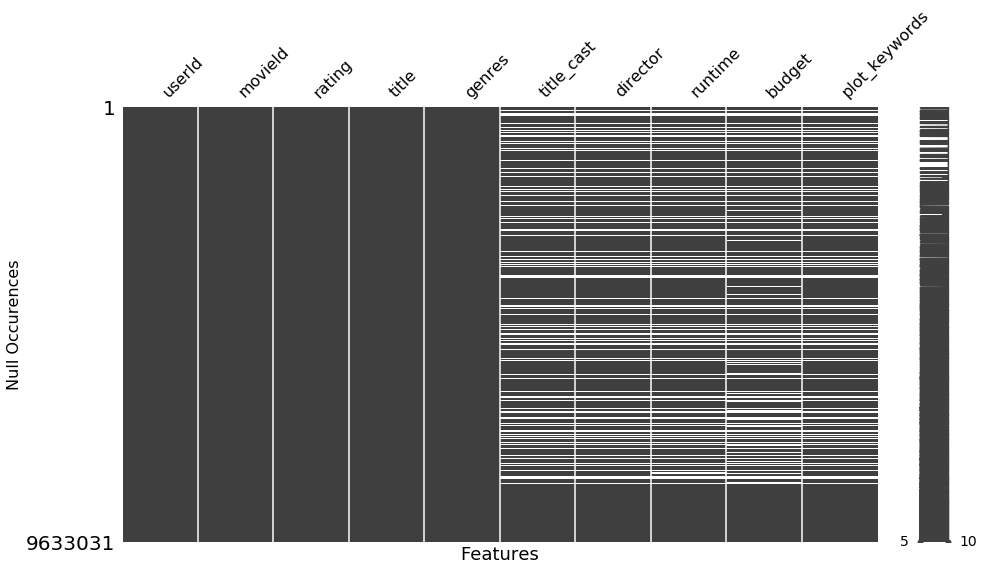

In [9]:
missingno.matrix(data, figsize=(15,8))
plt.xlabel('Features', fontsize=18)
plt.ylabel('Null Occurences', fontsize=16)
plt.show()

As we can see from the visual above, the ***budget***, ***runtime***, ***title_cast*** and **director** columns have missing values. But this does not give any information on how many rows in these columns have missing values. We'll use the function defined below to show the number of missing values in each of the identified columns and what percentage of the data is missing.

In [10]:
def missing_values_table(df):
  '''
  Identify and show the missing values in a data set.
  params: df (dataframe)
  returns: renamed_columns (dataframe)
  '''

  mis_val = df.isnull().sum()
    
  mis_val_percent = 100 * df.isnull().sum() / len(df)
  
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
  
  renamed_columns = mis_val_table.rename(columns = 
                                         {0 : 'Missing Values',
                                          1: '% of Total Values'})
  
  renamed_columns = renamed_columns[renamed_columns.iloc[:,1] != 0]

  renamed_columns = renamed_columns.sort_values('% of Total Values',ascending=False)
  
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\nThere are " 
         + str(renamed_columns.shape[0]) + " columns that have missing values.")
  
  # Return the dataframe with missing information
  return renamed_columns

In [11]:
missing_values_table(data)

Your selected dataframe has 10 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
budget,3152276,32.72
runtime,2653058,27.54
plot_keywords,2610043,27.09
title_cast,2604407,27.04
director,2602688,27.02


The number of missing values in these columns is not so high that it could affect our analysis of the data. The only column we will be using that will be affected is the ***runtime*** column. What we will do is  impute all the missing values in this column with the mean of the data

In [12]:
data['runtime'].fillna(data['runtime'].mean(), inplace=True)

As we can see below, the ***runtime*** column does not appear to be on the list of columns with missing values.

In [13]:
missing_values_table(data)

Your selected dataframe has 10 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
budget,3152276,32.72
plot_keywords,2610043,27.09
title_cast,2604407,27.04
director,2602688,27.02


#EDA
In this section we look at how our features interact to and relate with each other. The features we will be using in our analysis are:

- Title
- Title Cast
- Runtime
- Director
- Genres
- Year, which we will create
- Plot Keywords

## What is the most rated movie?

In [14]:
# check if there are multiple movies with the same title, and if so, determine if they are actually duplicates
result = data[data['title'].isin(data[data.duplicated(['title'])]['title'])]
result.sort_values('title')

,userId,movieId,rating,title,genres,title_cast,director,runtime,budget,plot_keywords
9532427,156067,51372,0.50,"""Great Performances"" Cats (1998)",Musical,Elaine Paige|John Mills|Ken Page|Rosemarie For...,T.S. Eliot,120.00,NaN,ballet|aging|kidnapping|magician
9532422,28522,51372,2.50,"""Great Performances"" Cats (1998)",Musical,Elaine Paige|John Mills|Ken Page|Rosemarie For...,T.S. Eliot,120.00,NaN,ballet|aging|kidnapping|magician
9532423,22836,51372,5.00,"""Great Performances"" Cats (1998)",Musical,Elaine Paige|John Mills|Ken Page|Rosemarie For...,T.S. Eliot,120.00,NaN,ballet|aging|kidnapping|magician
9532424,39162,51372,3.50,"""Great Performances"" Cats (1998)",Musical,Elaine Paige|John Mills|Ken Page|Rosemarie For...,T.S. Eliot,120.00,NaN,ballet|aging|kidnapping|magician
9532425,47571,51372,0.50,"""Great Performances"" Cats (1998)",Musical,Elaine Paige|John Mills|Ken Page|Rosemarie For...,T.S. Eliot,120.00,NaN,ballet|aging|kidnapping|magician
...,...,...,...,...,...,...,...,...,...,...
9609333,72315,130640,2.00,貞子3D (2012),Horror,Satomi Ishihara|Kôji Seto|Ryôsei Tayama|Tsutom...,Kôji Suzuki,96.00,NaN,entering tv screen|screaming woman|screaming i...
9609332,71897,130640,4.00,貞子3D (2012),Horror,Satomi Ishihara|Kôji Seto|Ryôsei Tayama|Tsutom...,Kôji Suzuki,96.00,NaN,entering tv screen|screaming woman|screaming i...
9609331,71265,130640,4.00,貞子3D (2012),Horror,Satomi Ishihara|Kôji Seto|Ryôsei Tayama|Tsutom...,Kôji Suzuki,96.00,NaN,entering tv screen|screaming woman|screaming i...
9609330,73268,130640,1.00,貞子3D (2012),Horror,Satomi Ishihara|Kôji Seto|Ryôsei Tayama|Tsutom...,Kôji Suzuki,96.00,NaN,entering tv screen|screaming woman|screaming i...


In [15]:
# Most rated titles
most_rated = pd.DataFrame(result.groupby('title')['rating']
                          .count()
                          .sort_values(ascending=False)).reset_index()

Here we show how the top 5 movies that have been rated the most. **Shawshank Redemption, The (1994)** has the highest number of ratings.

In [16]:
most_rated = most_rated.rename(columns={"rating": "num_of_ratings"})
most_rated.reindex()
most_rated.head()

,title,num_of_ratings
0,"Shawshank Redemption, The (1994)",32831
1,Forrest Gump (1994),32383
2,Pulp Fiction (1994),31697
3,"Silence of the Lambs, The (1991)",29444
4,"Matrix, The (1999)",29014


Upon inspection of the graph below, we see that 9 out of the top 10 most rated movies were released **between 1991 and 1999**, with the first three all released in the same year, **1994**. One explanation for the most rated movies being some of the older ones in the dataset is that they have been around longer and have thus have a longer opportunity to be rated than movies that came out later.


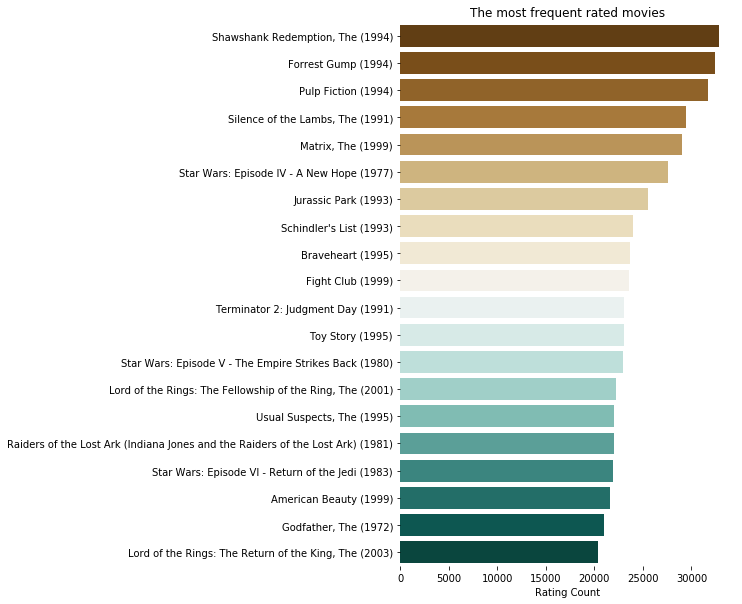

In [17]:
# plot the highest rated movies
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data=most_rated[0:20],y='title',x='num_of_ratings',palette = sns.color_palette("BrBG", 20))
ax.set(ylabel="",
       xlabel="Rating Count")
ax.title.set_text('The most frequent rated movies')
sns.despine(left=True, bottom=True)

In [18]:
rated = pd.DataFrame(result.groupby('title')['rating']
                          .mean()
                          .sort_values(ascending=False)).reset_index()

Now we'll add a column with the average rating that a movie has recieved.

In [19]:
rated

,title,rating
0,Favor (2013),5.00
1,Excuse Me for Living (2012),5.00
2,Limuzins Janu nakts krasa (1981),5.00
3,Crazy Mama (1975),4.75
4,Remarkable Power (2008),4.75
...,...,...
21632,Blutzbrüdaz (2013),0.50
21633,"Oh, Susanna! (1936)",0.50
21634,"Ah of Life, The (2010)",0.50
21635,Tyler Perry's A Madea Christmas (2011),0.50


In [20]:
rated['count'] = rated.groupby('rating')['rating'].transform('count')

In [21]:
rated

,title,rating,count
0,Favor (2013),5.00,3
1,Excuse Me for Living (2012),5.00,3
2,Limuzins Janu nakts krasa (1981),5.00,3
3,Crazy Mama (1975),4.75,17
4,Remarkable Power (2008),4.75,17
...,...,...,...
21632,Blutzbrüdaz (2013),0.50,12
21633,"Oh, Susanna! (1936)",0.50,12
21634,"Ah of Life, The (2010)",0.50,12
21635,Tyler Perry's A Madea Christmas (2011),0.50,12


## Which movies have the shortest and longest runtime?


What is the average runtime for a movie in the data?

In [22]:
# calculate the average movie duration
round(data['runtime'].mean(),2)

116.1

- The average runtime is 116.1. 
- This equates to ~1.9 hours, which is a normal runtime for movies. 

What is the average rating for
- movies longer than 2 hours?
- movies shorter than 2 hours?

In [23]:
# calculate the average star rating for movies 2 hours or longer
# calculate the average star rating for movies shorter than 2 hours
print('Avg. star rating for movies 2 hours or longer: ', round(data[data['runtime'] >= 120]['rating'].mean(),2), 
 '\nAvg. star rating for movies shorter than 2 hours: ', round(data[data['runtime'] < 120]['rating'].mean(),2))

Avg. star rating for movies 2 hours or longer:  3.66 
Avg. star rating for movies shorter than 2 hours:  3.49


From our research we found that **'Cleopatra (1963)'**, is the longest Hollywood movie ever released with a runtime of **248**, which is **~4 hours and 8 minutes**. We will use this as a benchmark and only select movies that are shorter than this to run our analysis. This is due to the fact that in our dataset we found that there are also short television series. So to eliminate any error we will remove them from consideration.

In [24]:
shorter_runtime = data[data['runtime'] <= 248] 

In [25]:
shorter_runtime.head()

,userId,movieId,rating,title,genres,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.00,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.00,"$15,000,000",dwarf|bruges|irish|hitman
1,87388,57669,3.50,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.00,"$15,000,000",dwarf|bruges|irish|hitman
2,137050,57669,4.00,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.00,"$15,000,000",dwarf|bruges|irish|hitman
3,120490,57669,4.50,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.00,"$15,000,000",dwarf|bruges|irish|hitman
4,50616,57669,4.50,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.00,"$15,000,000",dwarf|bruges|irish|hitman


Next, we define a function to find the minimum and maximum runtimes.

In [26]:
def find_minmax(column_name):
  '''
  This function looks at the maximum and minimum profits of the movies,
  then returns the maximum runtime.
  The function uses the function 'idmin' to find the index of lowest profit movie.
  and 'idmax' to find the index of Highest profit movie.
  The function prints the row related to this index.
  params: column name (str)
  returns: highest and lowest runtime info (dataframe)
  '''
  #use the function 'idmin' to find the index of lowest profit movie.
  min_index = shorter_runtime[column_name].idxmin()

  #use the function 'idmax' to find the index of Highest profit movie.
  high_index = shorter_runtime[column_name].idxmax()

  high = pd.DataFrame(shorter_runtime.loc[high_index,:])
  low = pd.DataFrame(shorter_runtime.loc[min_index,:])
  
  #print the movie with high and low profit
  print("Movie Which Has Highest "+ column_name + " : ",shorter_runtime['title'][high_index])
  print("Movie Which Has Lowest "+ column_name + "  : ",shorter_runtime['title'][min_index])
  
  output = pd.concat([high,low],axis = 1)
  # hardcoded, needs to be changed
  output = output.rename(columns={8148250: 'highest runtime ',9438402:'lowest runtime'})
  return output

In [27]:
#call the find_minmax function.
find_minmax('runtime')

Movie Which Has Highest runtime :  My Voyage to Italy (Il mio viaggio in Italia) (1999)
Movie Which Has Lowest runtime  :  Stille Nacht I: Dramolet (1988)


,highest runtime,lowest runtime
userId,160506,124638
movieId,8755,126050
rating,3.00,2.50
title,My Voyage to Italy (Il mio viaggio in Italia) ...,Stille Nacht I: Dramolet (1988)
genres,Documentary,Animation
title_cast,Martin Scorsese,NaN
director,Suso Cecchi D'Amico,Stephen Quay
runtime,246.00,1.00
budget,NaN,NaN
plot_keywords,film history|filmmaking|italian cinema|italian...,magnet|doll|spoon|moth


Above we show which of the movies that have runtime less than or equal to 248 have the longest and which one has the shortest runtime. From the output you will see that ***My Voyage to Italy (Il mio viaggio in Italia) (1999)*** has the longest runtime with **246 minutes** and ***Stille Nacht I: Dramolet (1988)*** with only **1 minute**. We also ouput some other details about the two movies.

In [28]:
info = pd.DataFrame(shorter_runtime['runtime'].sort_values(ascending = False))
info['original_title'] = shorter_runtime['title']
info.drop_duplicates(inplace = True)
info.reset_index(drop=True, inplace=True)

In [29]:
info

,runtime,original_title
0,246.00,My Voyage to Italy (Il mio viaggio in Italia) ...
1,244.00,At Berkeley (2013)
2,242.00,Hamlet (1996)
3,240.00,"Beach Boys: An American Family, The (2000)"
4,240.00,Bonnie and Clyde (2013)
...,...,...
23496,1.00,Four Heads Are Better Than One (Un homme de tê...
23497,1.00,The Kiss (1900)
23498,1.00,Dickson Greeting (1891)
23499,1.00,Santa Claus (1898)


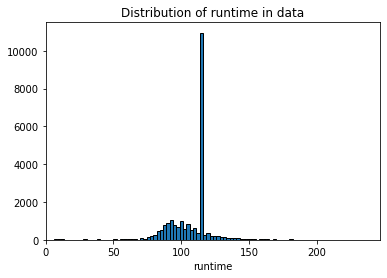

In [30]:
#histogram of the runtimes
plt.hist(info['runtime'], bins = 100, edgecolor = 'k')
plt.xlabel('runtime') 
plt.title('Distribution of runtime in data')
plt.xlim([0,247])
plt.show()

The graph below shows the top 10 movies with the longest runtime. The runtime of the top 10 movies is in the range between 239-246 minutes. 70% of this top 10 have a runtime between 239-240, with 2 movies having a runtime of 239 minutes and 5 movies having a runtim of 240 minutes.This means that 50% of the top 10 have runtime equal to 240 minutes. The top 30% doesn't have a clustered runtime like the lower 70%. The top 3 deviate by 2 minutes from 242 minutes. within the top 10 movies with longest runtime there is no correlation with the year in which the movie was released, they are not ranked in the manner whereby the oldest movies have lower runtime than the recent movies but using the full dataset we can see that the recent movies are the ones that have the longest runtime compared to the older movies.

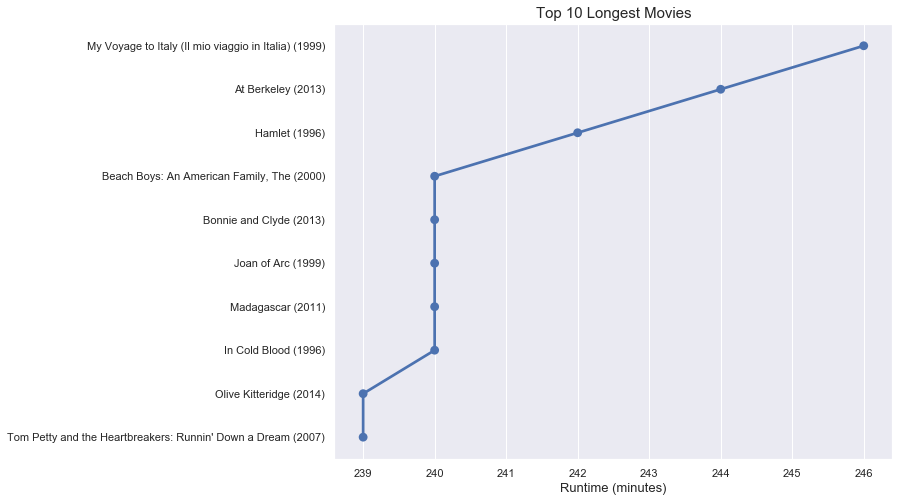

In [31]:
info_list = list(map(str,(info['original_title'])))
movie_titles = list(info_list[:10])
movie_runtimes = list(info['runtime'][:10])

#setup the figure size
sns.set(rc={'figure.figsize':(10,8)})

ax = sns.pointplot(x=movie_runtimes,y=movie_titles)
#setup the title and labels of the plot.
ax.set_title("Top 10 Longest Movies",fontsize = 15)
ax.set_xlabel("Runtime (minutes)",fontsize = 13)
sns.set_style("darkgrid")

## Which year has the highest release of movies?

Before we can do our analysis, we have to extract the year each movie was released from the titles and save them in a new column.

In [32]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don’t conflict with movies that have years in their titles
movies['year'] = movies['title'].str.extract("(\(\d\d\d\d\))",expand=False)
#Removing the parentheses
movies['year'] = movies['year'].str.extract("(\d\d\d\d)",expand=False)
#Removing the years from the ‘title’ column
movies['title'] = movies['title'].str.replace("(\(\d\d\d\d\))", "")
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies['title'] = movies['title'].apply(lambda x: x.strip())

In [33]:
pd.to_datetime(movies.year, format='%Y')

0       1995-01-01
1       1995-01-01
2       1995-01-01
3       1995-01-01
4       1995-01-01
           ...    
62418   2018-01-01
62419   2001-01-01
62420   2018-01-01
62421   2001-01-01
62422   1962-01-01
Name: year, Length: 62423, dtype: datetime64[ns]

In [34]:
year_df = pd.DataFrame(movies.groupby('year')['title'].count()).reset_index()
year_df.rename(columns={'title': 'num_of_titles'}, inplace=True)
year_df = year_df.sort_values(by='year', ascending=False)
year_df

,year,num_of_titles
134,2019,994
133,2018,2034
132,2017,2374
131,2016,2488
130,2015,2513
...,...,...
4,1887,1
3,1883,1
2,1880,1
1,1878,1


The graph below shows the number of movies released per year form **1874-2019**. We can see that there is an upward trend from **1874 to 2015** meaning the number of movies released per year increased and this could be reasoned by the advancement in technology that has been happening around the would. Around the **1800s**, it took time for a movie to be released and there were not many movie production campanies to release many movies in a given year. The number of movies released per year were on some sort of a plateu almost as constant between **1874 and the late 1920s**. The numbers increased gradually each year from the 1930s to 1990, the increase could be caused by the fact that this was during the time the **first electronic Television was first successfully demonstrated in (1927) by Philo Taylor**. This introduction of electric television made a huge difference in the movie industry as it uplifted the number of movies from that plateu, to an upward trend. Then there is a drastic increase in the number of movies released from 1990-2015 since during this time most countries around the world have advanced in technology meaning more movies can ve released in a shott period of time and there were also many movie production campanies.The movie business is now maing alot of money and more people are investing on them so it is likely that the trend will increase.

But thats not the case, from 2015-2019 there is a drastic decrease in movies released per year. This is caused by the fact that our dataset has a portion of recent movies, if we could have a dataset that covers all the movies in the world the graph would continue its upward trend.

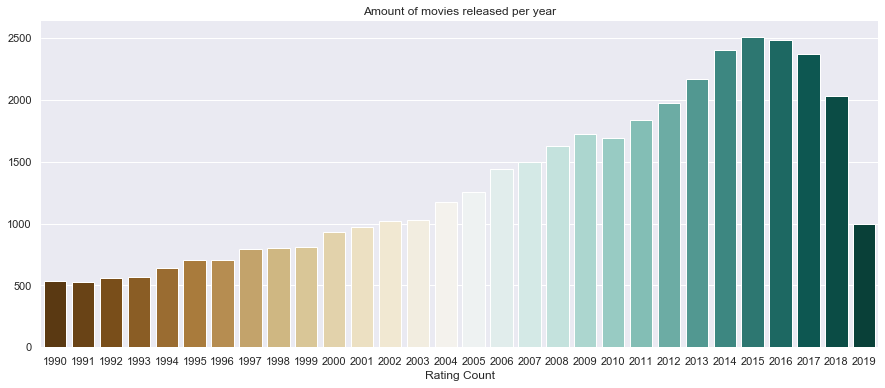

In [35]:
# plot the highest rated movies
f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=year_df[0:30],y='num_of_titles',x='year',palette = sns.color_palette("BrBG", 30))
ax.set(ylabel="",
       xlabel="Rating Count")
ax.title.set_text('Amount of movies released per year')
sns.despine(left=True, bottom=True)

In [36]:
def decades(year):
  '''
  This function defines the year based on the decade that it is released.
  params: year (int)
  returns: decade (str)
  '''
  decade = str(floor(year/10))
  return decade+"0s"

In [37]:
year_df['decade'] = year_df['year'].astype(int)
year_df['decade'] = year_df['decade'].apply(decades)
year_df

,year,num_of_titles,decade
134,2019,994,2010s
133,2018,2034,2010s
132,2017,2374,2010s
131,2016,2488,2010s
130,2015,2513,2010s
...,...,...,...
4,1887,1,1880s
3,1883,1,1880s
2,1880,1,1880s
1,1878,1,1870s


In [38]:
yearly_release = year_df.groupby('decade')['num_of_titles'].sum().reset_index()
yearly_release

,decade,num_of_titles
0,1870s,2
1,1880s,7
2,1890s,108
3,1900s,155
4,1910s,239
5,1920s,576
6,1930s,2069
7,1940s,2326
8,1950s,2981
9,1960s,3586


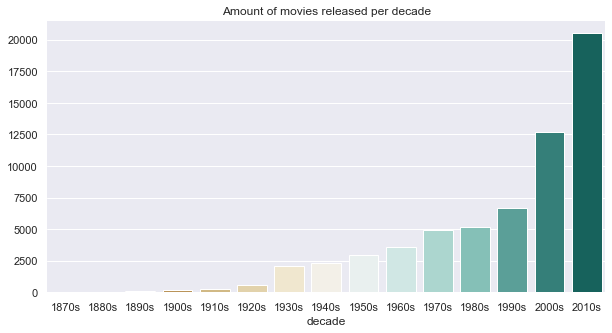

In [39]:
# plot the highest rated movies
f, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=yearly_release,y='num_of_titles',x='decade',palette = sns.color_palette("BrBG", 16))
ax.set(ylabel="",
       xlabel="decade")
ax.title.set_text('Amount of movies released per decade')
sns.despine(left=True, bottom=True)

The graph above shows the distribution on movies in the dataset. At first glance, it is clear that the **2010s** have the highest number of movies released in one decade.

## Which Genre Has The Highest Release Of Movies?

Most of the movies in our dataframe have multiple genres associate with them, each separated by a ' | ' character. In order to do a thorrough analysis of the genres represented in our dataset, we will define a function that separates the genres at the pipe and isolate them.

In [40]:
#make a function that will split the string and return the count of each genre.
def count_genre(data,string):
  '''
  This function will split a string based on '|' and 
  return the count of each genre.
  params: string (str)
  return: counter
  '''
  #concatenate all the rows of the genres.
  data_plot = data[string].str.cat(sep = '|')
  df = pd.Series(data_plot.split('|'))

  #counts each of the genre and return.
  counter = df.value_counts(ascending=False)
  return counter

Now we'll create a dataframe with the genres and the counts of the movies that correspond to them. These values might be false as our movies are duplicated, and occur more than once. While this might be the case, it is still an accurate representation.

In [41]:
#call the function for counting the movies of each genre.
total_genre_movies = pd.DataFrame(count_genre(data,'genres'))
total_genre_movies = total_genre_movies.reset_index()
total_genre_movies =  total_genre_movies.rename(columns={'index': 'genre',0:'count'})
total_genre_movies

,genre,count
0,Drama,4256763
1,Comedy,3480397
2,Action,2856958
3,Thriller,2622343
4,Adventure,2221248
5,Romance,1775419
6,Crime,1642048
7,Sci-Fi,1622841
8,Fantasy,1090191
9,Children,819479


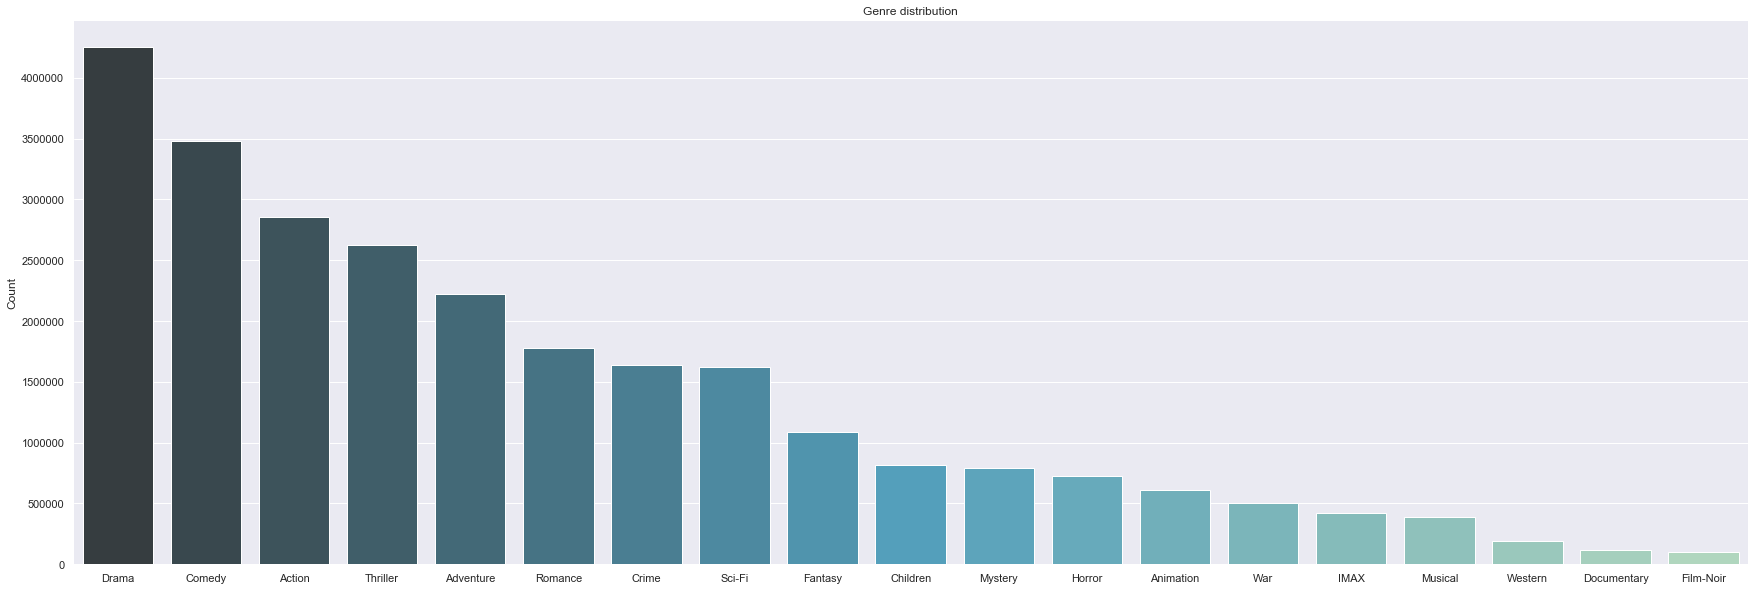

In [42]:
# plot the distribution of genres
f, ax = plt.subplots(figsize=(30, 10))
sns.barplot(data=total_genre_movies[:-1],y='count',x='genre',palette = sns.color_palette("GnBu_d",19))
ax.set(ylabel="Count",
       xlabel="")
ax.title.set_text('Genre distribution')
sns.despine(left=True, bottom=True)

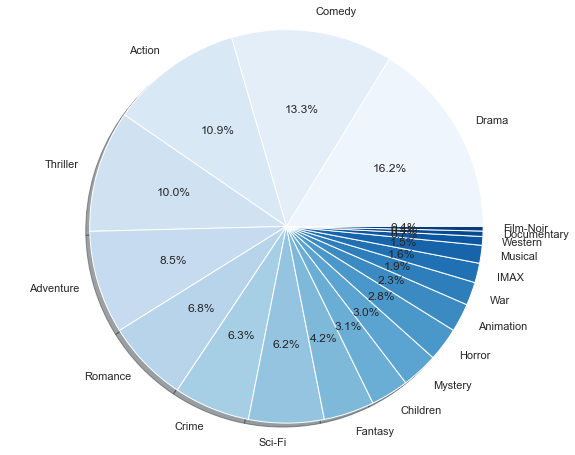

In [43]:
fig1, ax1 = plt.subplots()
ax1.pie(total_genre_movies['count'][:-1], labels=total_genre_movies['genre'][:-1], autopct='%1.1f%%', shadow=True,colors=sns.color_palette("Blues",19))
ax1.axis('equal')
plt.show()

The graph above show the number of movies in the different genres that the dataset has. **Drama** holds the most number of movie ratings in the dataset followed by **comedy** and **action**. This makes sense because these are the most popular and most loved movie genres. Drama comes out at the top since our database represents mostly movies released in the **1900s** and during that time there were alot of Drama movies released compared to the other genres. For instance, **documentary** is the second last genre simply because it is only now that there are alot of documentaries released. During the 1900s there weren't many people interested in watching documentaries. The **Film noir** genre was only popular during the **1930s and early 1940s** and these are **propaganda-type films** used to cheer on people during the hard times of depression and World War II, theres only a few of these movies thats why they are at the bottom. Most of these genres have increased in numbers after the 2000s and this dataset doesn't have much movies in the 2000s maybe with a more recent dataset of movies we might see a shift in the

## Most Frequent Actor?

In [44]:
#call the 'count_genre' function which we made earlier for spiliing and counting genres.
#it will count number of movies done by each actor.
count_actor_films = pd.DataFrame(count_genre(data,'title_cast'))
count_actor_films = count_actor_films.reset_index()
count_actor_films =  count_actor_films.rename(columns={'index': 'cast',0:'count'})
count_actor_films

,cast,count
0,Tom Hanks,196784
1,Samuel L. Jackson,191508
2,Morgan Freeman,164540
3,Brad Pitt,159198
4,Bruce Willis,158410
...,...,...
104968,Elise Larnicol,1
104969,Frances Mercer,1
104970,Robbie Rives,1
104971,Paola Binetti,1


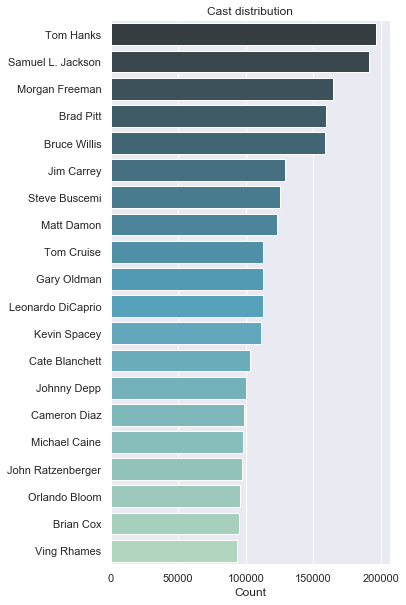

In [46]:
# plot the distribution of cast
f, ax = plt.subplots(figsize=(5, 10))
sns.barplot(data=count_actor_films[0:20],y='cast',x='count',palette = sns.color_palette("GnBu_d",20))
ax.set(ylabel="",
       xlabel="Count")
ax.title.set_text('Cast distribution')
sns.despine(left=True, bottom=True)

The graph above shows the number of times movies with specific actors in the dataset have been rated. **Tom Hanks** takes the lead with more than **195000** movie ratings to his name. In second place is **Samuel L.Jackson** followed by **Morgan Freeman** in third place. It makes sense that the top 3 actors with the most ratings associated with their names also star in the top 3 most rated movies **(refer to 'most rated movies' section)**. Then the remaining 17 actors have almost the same number of movies under their names. This is also a reflection of the time in which these movies were released, during the 90s these actors were the top guys in the movie industry. another thing to note is that most of the movies in the dataset are American movies, hence some of the actors that you might expect to be in the top 20 are not here, take for example Jackie Chan who has stared in more than 120 movies, signifiantly more than the actor with the most movie appearences in our dataset **(Samuel L. Jackson has the highest movie appearences in the dataset with a title count of 80)**. But it is also important to note that having the most number of movies under your bet does not equate to the most ratings.

## Top 20 Director Who Directs Maximum Movies?

In [47]:
count_director_movies = pd.DataFrame(count_genre(data,'director'))
count_director_movies = count_director_movies.reset_index()
count_director_movies =  count_director_movies.rename(columns={'index': 'director',0:'count'})
count_director_movies

,director,count
0,Quentin Tarantino,109919
1,Michael Crichton,65157
2,J.R.R. Tolkien,62963
3,Lilly Wachowski,60988
4,Stephen King,59903
...,...,...
9990,Roland af Hällström,1
9991,Billy Roche,1
9992,Mehdi Ben Attia,1
9993,Salvador García Ruiz,1


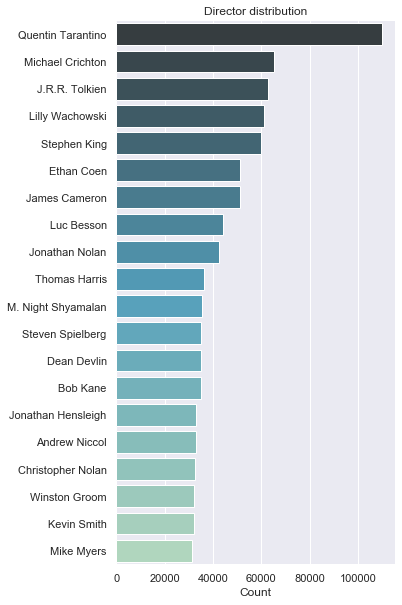

In [48]:
# plot the distribution of director
f, ax = plt.subplots(figsize=(5, 10))
sns.barplot(data=count_director_movies[0:20],y='director',x='count',palette = sns.color_palette("GnBu_d",20))
ax.set(ylabel="",
       xlabel="Count")
ax.title.set_text('Director distribution')
sns.despine(left=True, bottom=True)

## Most Popular Keyword?

In [49]:
keywords = pd.DataFrame( count_genre(data,'plot_keywords'))
keywords = keywords.reset_index()
keywords = keywords.rename(columns={'index': 'keywords',0:'count'})
keywords

,keywords,count
0,superhero,117178
1,neo noir,114580
2,serial killer,97089
3,alien,95570
4,surprise ending,93863
...,...,...
15950,dr. jekyll and mr. hyde characters,1
15951,dope,1
15952,batteries,1
15953,shakespeare's the winter's tale,1


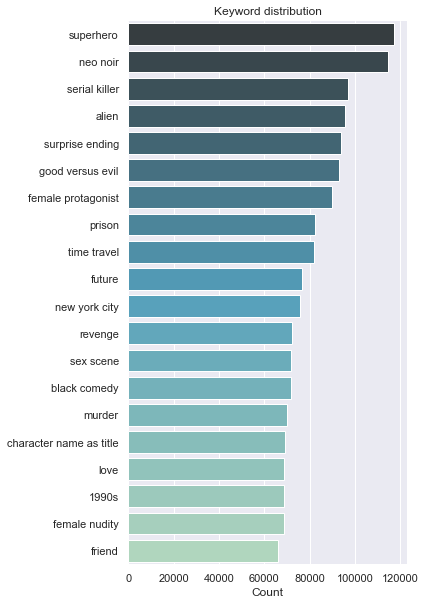

In [50]:
# plot the distribution of director
f, ax = plt.subplots(figsize=(5, 10))
sns.barplot(data=keywords[0:20],y='keywords',x='count',palette = sns.color_palette("GnBu_d",20))
ax.set(ylabel="",
       xlabel="Count")
ax.title.set_text('Keyword distribution')
sns.despine(left=True, bottom=True)

In [51]:
#drop faulty line
keywords = keywords.drop(index=15454)

In [ ]:
keywords_df = data[['plot_keywords']]
keywords_df.dropna(inplace=True)
keywords_df['keyword'] = keywords_df['plot_keywords'].str.split('|')
keywords_df['keyword'] = keywords_df['keyword'].apply(lambda x: " ".join(x))

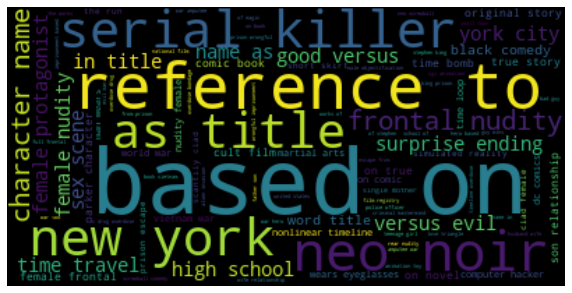

In [53]:
# define text to be featured in wordcloud
text =  " ".join(review for review in keywords_df['keyword'])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The wordcloud above shows the most frequent keywords that the movies in the database have. These keywords are a reflection of the top genre in the dataset namely Drama. If you watch this genre, it is very likely that the movie will have these keywords and that is why these movies have high age restictions and are mostly played at night. That is done to filter out children from watching these movies. Does this mean that most people enjoy watching movies with these kind of keywords? well this dataset seems to agree that users tend to enjoy watching more of F-rated movies, with sex scenes, murder, nudity to name a few keywords.

##How is the training data distributed?

Average rating in dataset: 3.5333951730983424


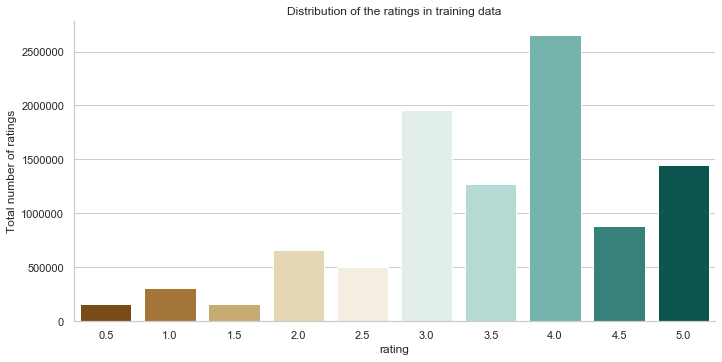

In [54]:
with sns.axes_style('whitegrid'):
    g = sns.catplot("rating", data=train, aspect=2.0,kind='count', palette = sns.color_palette("BrBG", 10))
    g.set_ylabels("Total number of ratings")
    plt.title('Distribution of the ratings in training data')
print (f'Average rating in dataset: {np.mean(train["rating"])}')

In [55]:
# The minimum and maximum ratings given by the users
print('The minimum rating given is:',data['rating'].min())
print('The maximum rating given is:',data['rating'].max())

The minimum rating given is: 0.5
The maximum rating given is: 5.0


In the graph above we display the distribution of the ratings for the movies in the training data. We count how many movies have been given a certain rating with 5 being the highest rating that a movie can get. most of the movies have been given a rating of 4 which means that most people enjoy most of the movies in the data. The rating range between 3-4 is the one that is used the most. There's also quite a number of 5 star rated movies, this rating holds the 3rd most number of ratings in the data which also supports that most of the people love these movies. There is no movie rated zero atleast, the lowest rating that these movies are given is 0.5 and it holds the lowest number of ratings. The poorly rated movies have ratings from 0.5-2.5 and they all have low number of movies.

The reason why the there arent so many poorly rated movies could be since a movie is rated poorly only a few people will watch that movie and also most people tend to not rate movies they dont enjoy and some don't even finish watching the movie hence there is only a few number of recorded ratings in the range 0.5-2.5

In [56]:
# Define a function that creates ranges for ratings
def rating_range(rating):
  '''Takes a rating as input and returns the range that the rating is in.
     params: rating (str)
     return: rating range (str)
  '''
  rating = int(rating)
  if rating < 1:    
    return '0-1'
  elif rating <2:
    return'1-2'
  elif rating <3:
    return '2-3'
  elif rating <4:
    return '3-4'
  else:
    return '4-5'

In [57]:
movie_rating=data.groupby(['title'])['rating'].mean() # agg rating by mean
movie_rating=pd.DataFrame(movie_rating)

In [58]:
# Generate column to sum number of ratings per title
movie_rating['num of ratings'] = pd.DataFrame(data.groupby('title')['rating'].count())

In [59]:
movie_rating['range']=movie_rating['rating'].apply(rating_range)

The trend seen in the scatter plot is that there is a positive correlation between number of ratings and rating given.

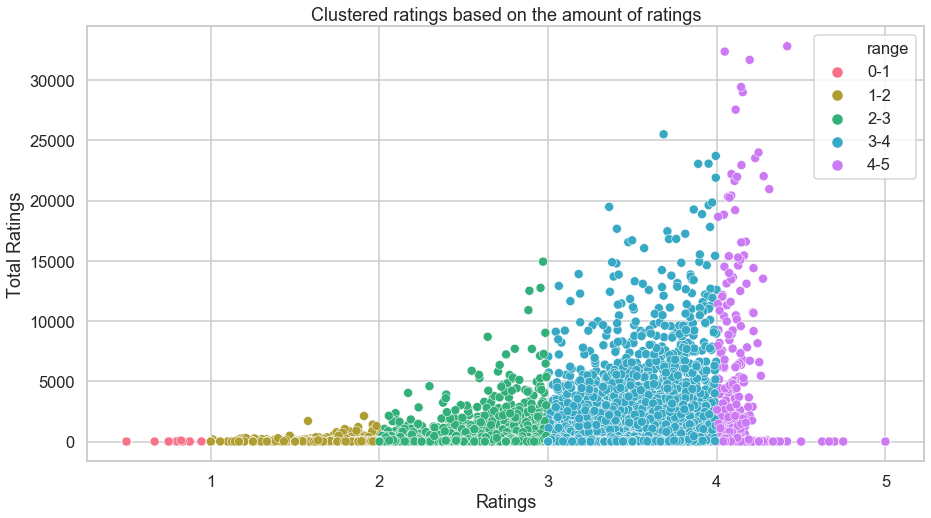

In [60]:
# Plot scatter plot illustrating the relationship between ratings and number of ratings
sns.set(style="whitegrid", context="talk")
f, ax = plt.subplots(figsize=(15, 8))
hue_legend=['0-1','1-2','2-3','3-4','4-5']
sns.scatterplot(x=movie_rating['rating'], y=movie_rating['num of ratings'],hue_order=hue_legend,
                hue = movie_rating['range'],palette="husl",sizes=(1, 8),linewidth=0.5,
                data=movie_rating, ax=ax)
plt.xlabel('Ratings') 
plt.ylabel('Total Ratings')
plt.title('Clustered ratings based on the amount of ratings') 
plt.show()

## Modelling

So how do we make recommendations?

There are two approaches to recommending movies:
 - finding **similar users** or collaborative based filtering
 - finding **similar content** or content based filtering

![both%20models.png](https://github.com/monicafar147/unsupervised-predict-streamlit-template/blob/modelling/resources/imgs/both%20models.png?raw=1)

As we can see from the image above:

There are two primary sets of entities:
- the Users ( individuals who interact with the items)
- the Items (a thing which is consumed)

***Similarity*** :

similarity can be found in many ways but a method called cosine similarity is usually used.

similarity can be found between many things such as :

Items can be:
- movies
- books
- online purchases
- clicked-on items
- users who have interacted with these items

Cosine similarity is the measure of similarity between two vectors, by computing the cosine of the angle between two vectors projected into multidimensional space. and can be demonstrated in the image below.

![cosine%20similarity.png](https://github.com/monicafar147/unsupervised-predict-streamlit-template/blob/modelling/resources/imgs/cosine%20similarity.png?raw=1)

### Collaborative based prediction

Let's have a closer look at collaborative filtering.
As you can see here we are comparing the similarity between users in order to predict what another user would want to watch.


![collab%20model.png](https://github.com/monicafar147/unsupervised-predict-streamlit-template/blob/modelling/resources/imgs/collab%20model.png?raw=1)

Here if user 1 watched the same movie as user 2 then other movies that user 2 watched will be recommended to user 1

### Cold Start Problem

A major downside to collaborative filtering is described by what is known as **'Cold-start problem'**.

This occurs when a new user starts using a system and there is no prior knowlodge in order to give this user recommendations
and can be demonstrated in the image below.A shop with no ratings would have no idea how to recommend a product to a new user. Luckily we can solve this problem by making the first recommendation using the most popular item in the shop.

![cold%20start.png](https://github.com/monicafar147/unsupervised-predict-streamlit-template/blob/modelling/resources/imgs/cold%20start.png?raw=1)

### Surprise Library

Luckly the **Surprise Library** has packages which will assist us in carrying out the collaborative based approach.

Surprise is a library used to build and analyze recommender systems that deal with explicit rating data.
Let's make some predictions using surprise. We will need to use the Reader and Dataset class from the surprise library to get the data in a format that Surprise understands.

In [61]:
# Load data into format that Surprise understands using Dataset class from surprise
reader = Reader(rating_scale=(1, 5))

#The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)

# We are using the full train dataset to train the model here
trainset = data.build_full_trainset()

We can now use this dataset as we please

### SVD Algorithm

One of the biggest issues with collaborative filtering is that as the user base increases, the matrix of user to items increases as well. This can result in very large matrices which take up vasts amount of memory. The sigular value decomposition algorithm or SVD algorithm helps us deal with this large matrix by splitting it up into two smaller matrices.

![matrix%20factorization.png](https://github.com/monicafar147/unsupervised-predict-streamlit-template/blob/modelling/resources/imgs/matrix%20factorization.png?raw=1)


This tye of model was made popular during the Netflix prize challenge where Netflix offered $1000,000 to anyone who could improve their recommendation algorithm by 10 percent. 

The SVD model is essentially a matrix factorization model used in order to assist in memory intensive tasks. Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices as demonstrated below.(Wikipedia)

Let's train our SVD model and predict a rating for a movie :

In [62]:
# Build an algorithm, and training it is as easy as 2 lines of code
algo = SVD(n_factors = 200 , lr_all = 0.005 , reg_all = 0.02 , n_epochs = 40 , init_std_dev = 0.05)
algo.fit(trainset)

In [63]:
# Pickle model for later use
model_save_path = "SVD_full_dataset.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(algo,file)

Example on how to predict using the SVD algorithm

In [64]:
# Let's predict the rating user 1 would make on movie ID 306 which is Forest Gump.
uid = str(1)
iid = str(306)

pred = algo.predict(uid, iid, r_ui=4, verbose=True)
pred

user: 1          item: 306        r_ui = 4.00   est = 3.53   {'was_impossible': False}


Prediction(uid='1', iid='306', r_ui=4, est=3.5333951730983424, details={'was_impossible': False})

### Predict ratings of test data set

Here we predict from the test data which was provided to us. This data consists of over 5 million datapoints of a userID and a moviedID which need to be predicted

In [65]:
# Import test data
test_df = pd.read_csv('Documents/movies/test.csv')

In [66]:
# Predict on our test data
predcol = []
for _, row in test_df.iterrows():
    x = (algo.predict(row.userId, row.movieId))
    pred = x[3]
    predcol.append(pred)

In [67]:
# check if the prediction length is the same as input length
len(predcol) == len(test_df)

True

In [68]:
# Convert columns to string in order to prep for concatenating
test_df['userId'] = test_df['userId'].astype(str)
test_df['movieId'] = test_df['movieId'].astype(str)

# Create submission column ID
test_df['Id'] =test_df['userId']+'_'+test_df['movieId']

# Create new dataframe
kaggle_df = pd.DataFrame(
    {'Id': test_df['Id'],
     'rating': predcol
    })

# Export to csv
kaggle_df.to_csv("SVD_base.csv",index=False)

### Top Ten Movies (collaborative filtering)

What good would a recommder system be if it could not recommend you a few movies! Here we look at the process we follow in order to get recommendations off of a few of your favorite movies.

In [70]:
# Importing train and test datasets
ratings_df = pd.read_csv('Documents/movies/train.csv').drop(columns=['timestamp'],axis=0)
movies_df = pd.read_csv('Documents/movies/movies.csv',sep = ',',delimiter=',')

As memory is a known issue for recommender systems - we will be running this notebook on an example as to save the user time and memory on their pc

In [71]:
# Create ratings subset (in order to save memory)
ratings_subset = ratings_df[:1000000]

In [73]:
# Unpickle model
model=pickle.load(open('SVD_full_dataset.pkl', 'rb'))

The next series of fuctions are used in order to get the recommendations off of the ground and avoid the cold start problem we spoke of earlier. This prediction_item function takes in an movie ID and then uses our SVD model to predict what score each user would give that movie. It then returns all of those predictions.

In [74]:
# Function to predict from an item id
def prediction_item(item_id):
    """Map a given favourite movie to users within the
       MovieLens dataset with the same preference.
    Parameters
    ----------
    item_id : int
        A MovieLens Movie ID.
    Returns
    -------
    list
        User IDs of users with similar high ratings for the given movie.
    """
    # Data preprosessing
    reader = Reader(rating_scale=(1, 5))
    load_df = Dataset.load_from_df(ratings_subset,reader)
    a_train = load_df.build_full_trainset()

    predictions = []
    for ui in a_train.all_users():
        predictions.append(model.predict(iid=item_id,uid=ui, verbose = False))
    return predictions

The pred_movies function takes in a movie and uses the prediction_item function above to return a list of 100 userIDs of the users who rated the movie highest.

In [75]:
# Function to return the user IDs of the users who have watched the movies to be predicted
def pred_movies(movie_list):
    """Maps the given favourite movies selected within the app to corresponding
    users within the MovieLens dataset.
    Parameters
    ----------
    movie_list : list
        Three favourite movies selected by the app user.
    Returns
    -------
    list
        User-ID's of users with similar high ratings for each movie.
    """
    # Store the id of users
    id_store=[]
    movie_ids = []
    for movie in movie_list:
        movie_ids.append(int(movies_df['movieId'][movies_df['title']==movie]))
    # For each movie selected by a user of the app,
    # predict a corresponding user within the dataset with the highest rating
    for i in movie_ids:
        predictions = prediction_item(item_id = i)
        predictions.sort(key=lambda x: x.est, reverse=True)
        # Take the top 10 user id's from each movie with highest rankings
        for pred in predictions[:100]:
            id_store.append(pred.uid)
    # Return a list of user id's
    return id_store

The next function takes in a list of 3 movies and how many recommendations you would like. It uses the 3 movies and to find the users who have a similar taste(using the functions above) and then checks what other movies those users have rated highly. It finds the top n movies and returns them.

In [76]:
# Function to predict the top n movies based off of a list of 3 movies
def collab_model(movie_list,top_n):
    """Short summary.
    Parameters
    ----------
    movie_list : type
        Description of parameter `movie_list`.
    top_n : type
        Description of parameter `top_n`.
    Returns
    -------
    type
        Description of returned object.
    """
    # get movie ids for movie_list
    movie_ids = []
    for movie in movie_list:
        movie_ids.append(int(movies_df['movieId'][movies_df['title']==movie]))

    # Create list of users which would rate these movies highly
    user_ids = pred_movies(movie_list)
    
    # Create dataframe of all the movies that these users have rated
    df_init_users = ratings_subset[ratings_subset['userId'].isin(user_ids)]
    
    # Add new user with ratings to userlist
    new_row1 = {'userId':200000, 'movieId':movie_ids[0], 'rating':5.0}
    new_row2 = {'userId':200000, 'movieId':movie_ids[1], 'rating':5.0}
    new_row3 = {'userId':200000, 'movieId':movie_ids[2], 'rating':4.5}
    df_init_users = df_init_users.append([new_row1,new_row2,new_row3], ignore_index=True)
    
    # Creating Util matrix,replace NANs and transpose
    util_matrix = pd.pivot_table(df_init_users,values='rating',columns='movieId',index='userId')
    util_matrix_norm = util_matrix.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)
    util_matrix_norm.fillna(0, inplace=True)
    util_matrix_norm = util_matrix_norm.T
    util_matrix_norm = util_matrix_norm.loc[:, (util_matrix_norm != 0).any(axis=0)]
    
    # Save the utility matrix in scipy's sparse matrix format
    util_matrix_sparse = sp.sparse.csr_matrix(util_matrix_norm.values)
    
    # Compute the similarity matrix using the cosine similarity metric
    user_similarity = cosine_similarity(util_matrix_sparse.T)
    
    # Save the matrix as a dataframe to allow for easier indexing  
    user_sim_df = pd.DataFrame(user_similarity,
                               index = util_matrix_norm.columns,
                               columns = util_matrix_norm.columns)
    
    user = 200000
    k=20
    # Gather the k users which are most similar to the reference user 
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:k+1]
    favorite_user_items = [] # <-- List of highest rated items gathered from the k users  
    most_common_favorites = {} # <-- Dictionary of highest rated items in common for the k users

    for i in sim_users:
        # Maximum rating given by the current user to an item 
        max_score = util_matrix_norm.loc[:, i].max()
        # Save the names of items maximally rated by the current user   
        favorite_user_items.append(util_matrix_norm[util_matrix_norm.loc[:, i]==max_score].index.tolist())

    # Loop over each user's favorite items and tally which ones are 
    # most popular overall.
    for item_collection in range(len(favorite_user_items)):
        for item in favorite_user_items[item_collection]:
            if item in most_common_favorites:
                most_common_favorites[item] += 1
            else:
                most_common_favorites[item] = 1
    # Sort the overall most popular items and return the top-N instances
    sorted_list = sorted(most_common_favorites.items(), key=operator.itemgetter(1), reverse=True)[:top_n+1]
    top_N = [x[0] for x in sorted_list]
    
    # Return Movie Names
    recommendations = []
    for movieid in top_N:
        recommendations.append(movies_df[movies_df['movieId']==movieid]['title'].tolist())
    recommendations = [item for sublist in recommendations for item in sublist]
    recommendations = [x for x in recommendations if x not in movie_list]
    recommendations[:top_n]
    return recommendations



Similar to the function above but only for 1 movie.

In [77]:
# Function to predict the top n movies based off of a list of 1 movie
def collab_model1(movie_list,top_n):
    """Short summary.
    Parameters
    ----------
    movie_list : type
        Description of parameter `movie_list`.
    top_n : type
        Description of parameter `top_n`.
    Returns
    -------
    type
        Description of returned object.
    """
    # get movie ids for movie_list
    movie_ids = []
    for movie in movie_list:
        movie_ids.append(int(movies_df['movieId'][movies_df['title']==movie]))

    # Create list of users which would rate these movies highly
    user_ids = pred_movies(movie_list)
    
    # Create dataframe of all the movies that these users have rated
    df_init_users = ratings_subset[ratings_subset['userId'].isin(user_ids)]
    
    # Add new user with ratings to userlist
    new_row1 = {'userId':200000, 'movieId':movie_ids[0], 'rating':5.0}
    df_init_users = df_init_users.append([new_row1], ignore_index=True)
    
    # Creating Util matrix,replace NANs and transpose
    util_matrix = pd.pivot_table(df_init_users,values='rating',columns='movieId',index='userId')
    util_matrix.fillna(0, inplace=True)
    util_matrix_norm = util_matrix.T
    util_matrix_norm = util_matrix_norm.loc[:, (util_matrix_norm != 0).any(axis=0)]
    
    # Save the utility matrix in scipy's sparse matrix format
    util_matrix_sparse = sp.sparse.csr_matrix(util_matrix_norm.values)
    
    # Compute the similarity matrix using the cosine similarity metric
    user_similarity = cosine_similarity(util_matrix_sparse.T)
    
    # Save the matrix as a dataframe to allow for easier indexing  
    user_sim_df = pd.DataFrame(user_similarity,
                               index = util_matrix_norm.columns,
                               columns = util_matrix_norm.columns)
    
    user = 200000
    k=20
    # Gather the k users which are most similar to the reference user 
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:k+1]
    favorite_user_items = [] # <-- List of highest rated items gathered from the k users  
    most_common_favorites = {} # <-- Dictionary of highest rated items in common for the k users

    for i in sim_users:
        # Maximum rating given by the current user to an item 
        max_score = util_matrix_norm.loc[:, i].max()
        # Save the names of items maximally rated by the current user   
        favorite_user_items.append(util_matrix_norm[util_matrix_norm.loc[:, i]==max_score].index.tolist())

    # Loop over each user's favorite items and tally which ones are 
    # most popular overall.
    for item_collection in range(len(favorite_user_items)):
        for item in favorite_user_items[item_collection]:
            if item in most_common_favorites:
                most_common_favorites[item] += 1
            else:
                most_common_favorites[item] = 1
    # Sort the overall most popular items and return the top-N instances
    sorted_list = sorted(most_common_favorites.items(), key=operator.itemgetter(1), reverse=True)[:top_n+1]
    top_N = [x[0] for x in sorted_list]
    
    # Return Movie Names
    recommendations = []
    for movieid in top_N:
        recommendations.append(movies_df[movies_df['movieId']==movieid]['title'].tolist())
    recommendations = [item for sublist in recommendations for item in sublist]
    recommendations = [x for x in recommendations if x not in movie_list]
    recommendations[:top_n]
    return recommendations

Let's have a look at some of the predictions our collaborative based movie recommender recommends:

In [78]:
mov = ["Karate Kid, The (2010)","Sorcerer's Apprentice, The (2010)","Knight and Day (2010)"]
collab_model(mov,10)

['Star Wars: Episode VI - Return of the Jedi (1983)',
 'Lord of the Rings: The Fellowship of the Ring, The (2001)',
 'The Hunger Games (2012)',
 'Aliens (1986)',
 'Batman & Robin (1997)',
 'Underworld (2003)',
 'I Am Legend (2007)',
 'Hidden Figures (2016)',
 'Forrest Gump (1994)',
 "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)"]

## 4.3 Content Based Approach
Let's have a closer look at collaborative filtering.

As can be seen in the image below - in content-based filtering, we seek to make recommendations based on how similar the properties or features of an item are to other items.

![Content%20based.png](https://github.com/monicafar147/unsupervised-predict-streamlit-template/blob/modelling/resources/imgs/Content%20based.png?raw=1)

In [79]:
# Generate a dataframe df by mergin the train, movies and imdb datsets on movieId
df=pd.merge(movies,train,how='outer',on='movieId') # movies and train outer join
df=pd.merge(df,imdb,how='left',on='movieId') # movies and train left join

In [80]:
column_list=['timestamp','runtime','budget']
df.drop(column_list,axis=1,inplace=True)

In [81]:
# Check df shape
row,column=df.shape
print('The dataframe has {} rows and {} columns.'.format(row, column))

The dataframe has 10014248 rows and 9 columns.


In [82]:
# Function takes in text as input and removes pipe
def remove_pipe(text):
  text=str (text)
  text=text.replace("|",",")
  return text

In [83]:
# Apply remove_pipe to columns title_cast and genres
df['genres']=df['genres'].fillna('') #fill missing values with blanks
df['title_cast']=df['title_cast'].fillna('') #fill missing values with blanks

df['title_cast']=df['title_cast'].apply(remove_pipe) #apply remove_pipe sunction
df['genres']=df['genres'].apply(remove_pipe)
df.head()

,movieId,title,genres,year,userId,rating,title_cast,director,plot_keywords
0,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995,158849.00,5.00,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,toy|rivalry|cowboy|cgi animation
1,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995,97203.00,5.00,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,toy|rivalry|cowboy|cgi animation
2,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995,161871.00,3.00,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,toy|rivalry|cowboy|cgi animation
3,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995,45117.00,4.00,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,toy|rivalry|cowboy|cgi animation
4,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995,27431.00,5.00,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,toy|rivalry|cowboy|cgi animation


Taking the df dataframe. A filtered dataframe with unique movie titles can be generated to remove duplicate movie titles due to multiple user ratings.

In [84]:
# A content column can be generated from the title_cast and genres columns
# This column will be used to build the content recommender

df['content']=df['genres']+' '+ df['title_cast'] 
df['content'][0]

'Adventure,Animation,Children,Comedy,Fantasy Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wallace Shawn,John Ratzenberger,Annie Potts,John Morris,Erik von Detten,Laurie Metcalf,R. Lee Ermey,Sarah Freeman,Penn Jillette,Jack Angel,Spencer Aste'

In [85]:
# A ratings dataframe can be generated from uniw\que movie titles and their average ratings across all users
ratings=df.groupby(['title'])['rating'].mean() #group by title and aggregate ratings
ratings=pd.DataFrame(ratings)
ratings=ratings.fillna(2) # fill missing values with generic score of 2 (40%)
ratings['num of ratings']=df.groupby(['title'])['rating'].count() #generate a column witht the total number of ratings
ratings.head(5)

,rating,num of ratings
title,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together",3.00,1
"""Great Performances"" Cats",2.75,67
#1 Cheerleader Camp,1.90,5
#Captured,2.00,0
#Female Pleasure,4.00,1


In [86]:
content=df.groupby(['title'])['content'].unique() #group by title and display unique values in a list
content=pd.DataFrame(content)

In [87]:
# Generate single dataframe
movie_df=pd.merge(ratings,content,on='title') #join on index
row,column=movie_df.shape
print('The dataframe has {} rows (representing unique movie titles) and {} columns.'.format(row, column))

The dataframe has 58529 rows (representing unique movie titles) and 3 columns.


In [88]:
# Sort move_df from highest to lowest num of ratings
movie_df=movie_df.sort_values('num of ratings',ascending=False)
movie_df.head(5)

,rating,num of ratings,content
title,,,
"Shawshank Redemption, The",4.42,32831,"[Crime,Drama Tim Robbins,Morgan Freeman,Bob Gu..."
Forrest Gump,4.05,32383,"[Comedy,Drama,Romance,War Tom Hanks,Rebecca Wi..."
Pulp Fiction,4.20,31697,"[Comedy,Crime,Drama,Thriller Tim Roth,Amanda P..."
"Silence of the Lambs, The",4.14,29444,"[Crime,Horror,Thriller Jodie Foster,Lawrence A..."
"Matrix, The",4.15,29014,"[Action,Sci-Fi,Thriller Keanu Reeves,Laurence ..."


In [89]:
# Function will remove items from lists into strings
def string(input):
  string=' '
  for i in input:
    string=string+str (i)
  return string

In [90]:
# Generate strings from lists
movie_df['content']=movie_df['content'].apply(string) #generate strings
movie_df['content'][1]

' Comedy,Drama,Romance,War Tom Hanks,Rebecca Williams,Sally Field,Michael Conner Humphreys,Harold G. Herthum,George Kelly,Bob Penny,John Randall,Sam Anderson,Margo Moorer,Ione M. Telech,Christine Seabrook,John Worsham,Peter Dobson,Siobhan Fallon Hogan'

The movie_df dataframe is the base from which the recommender is built. 

The content column will be the feature used, which will be vectorized and converted to a similarity matrix mxm

In [91]:
# A subset of the movies will be used. The greater the subset, the more memory is committed
# The cosine similiarity size is proportional to feature size
#First 15000 movies are selected
feature=movie_df['content'][0:15000]

In [92]:
# Set up vectorizer
vec=TfidfVectorizer(stop_words='english') # term frequency inverse document frequency

In [93]:
# Vectorize combined column
feature_vec=vec.fit_transform(feature)
row,column=feature_vec.shape
print('feature_vec is a sparse matrix with {} rows (representing unique movie titles) and {} columns.'.format(row, column))

feature_vec is a sparse matrix with 15000 rows (representing unique movie titles) and 46067 columns.



The cosine similarity will be used to determine how similar two entities are based off the angle between their two vectors formed. The closer a value is to 1, to higher the similarity

The cosine similarity is formed from the dot product of the feature_vec matrix and its transpose divided by the product of their magniudes.

In [94]:
# Use cosine similarity to get similarity matrix
sim_matrix =cosine_similarity(feature_vec,feature_vec)
row,column=sim_matrix.shape
print('The sim_mat matrix has {} rows and {} columns.'.format(row, column))

The sim_mat matrix has 15000 rows and 15000 columns.


In [95]:
# Double check
# Reset the move_df index as it will be used to generate a Series that will map sim_mat
movie_df=movie_df.reset_index()
movie_df.head(5)

,title,rating,num of ratings,content
0,"Shawshank Redemption, The",4.42,32831,"Crime,Drama Tim Robbins,Morgan Freeman,Bob Gu..."
1,Forrest Gump,4.05,32383,"Comedy,Drama,Romance,War Tom Hanks,Rebecca Wi..."
2,Pulp Fiction,4.20,31697,"Comedy,Crime,Drama,Thriller Tim Roth,Amanda P..."
3,"Silence of the Lambs, The",4.14,29444,"Crime,Horror,Thriller Jodie Foster,Lawrence A..."
4,"Matrix, The",4.15,29014,"Action,Sci-Fi,Thriller Keanu Reeves,Laurence ..."


In [96]:
# Index mapping
index_map = pd.Series(movie_df.index,index = movie_df['title']) # contains a series of the movie titles in movie_df
index_map

title
Shawshank Redemption, The           0
Forrest Gump                        1
Pulp Fiction                        2
Silence of the Lambs, The           3
Matrix, The                         4
                                ...  
Galaxy Hunter                   58524
Gajakessari                     58525
Gaily, Gaily                    58526
The Legend of Bloody Mary       58527
Gold of Rome (L'oro di Roma)    58528
Length: 58529, dtype: int64

In [97]:
# Function takes in a movie title as an input and returns 10 movie title recommendations

def recommendation(title):
  index = index_map[title] # returns the index of the argument title in index_map
  similarity = list(enumerate(sim_matrix[index])) # returns a list of with index and similarity
  similarity = sorted(similarity, key=lambda x: x[1], reverse=True) # sorts list in descending order
  similarity = similarity[1:11] # top 10 recommendations
  #return movie names using the mapping series
  movie_indices = [i[0] for i in similarity] # obtain indices for recommended movies
  return (movie_df['title'].iloc[movie_indices]) # filter movie_df for titles

Using the animated movie Aladdin from 1992. The recommender returns viewing options consisting of animated movies such as Moana, Robin Hood and Alice in Wonderland.


In [100]:
# Lets search for recommendations based off Aladdin
recommendations=recommendation('Aladdin')
recommend_list=list(recommendations)
recommend_list

['The Good Dinosaur',
 'DuckTales: The Movie - Treasure of the Lost Lamp',
 'Missing Link',
 "Olaf's Frozen Adventure",
 'Chipmunk Adventure, The',
 'Jack and the Beanstalk',
 'Lord of the Rings, The',
 'Land Before Time, The',
 'Kubo and the Two Strings',
 'Black Cauldron, The']

In [101]:
# pickle recommendation function
model_save_path = "content_based.pkl"
with open(model_save_path,'wb') as file:
  pickle.dump(recommendation,file)

In [103]:
#test content-based predictor
print("testing content based recommender")
model_load_path = "content_based.pkl"
with open(model_load_path,'rb') as file:
  content_based_predict = pickle.load(file)
  print(content_based_predict('Aladdin'))   

testing content based recommender
3834                                    The Good Dinosaur
8317     DuckTales: The Movie - Treasure of the Lost Lamp
11936                                        Missing Link
12935                             Olaf's Frozen Adventure
13845                             Chipmunk Adventure, The
11206                              Jack and the Beanstalk
1252                               Lord of the Rings, The
2183                                Land Before Time, The
2455                             Kubo and the Two Strings
2865                                  Black Cauldron, The
Name: title, dtype: object


In addition. We can predict what a user would rate a movie watched, based off previous ratings given.


In [104]:
# Recall df and sort based in descending order of movie rating
df=df.sort_values('rating',ascending=False)
df.head()

,movieId,title,genres,year,userId,rating,title_cast,director,plot_keywords,content
0,1,Toy Story,"Adventure,Animation,Children,Comedy,Fantasy",1995,158849.00,5.00,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,toy|rivalry|cowboy|cgi animation,"Adventure,Animation,Children,Comedy,Fantasy To..."
3184137,1393,Jerry Maguire,"Drama,Romance",1996,137780.00,5.00,"Tom Cruise,Cuba Gooding Jr.,Renée Zellweger,Ke...",Cameron Crowe,agent|sports agent|football|football player,"Drama,Romance Tom Cruise,Cuba Gooding Jr.,René..."
3184147,1393,Jerry Maguire,"Drama,Romance",1996,63376.00,5.00,"Tom Cruise,Cuba Gooding Jr.,Renée Zellweger,Ke...",Cameron Crowe,agent|sports agent|football|football player,"Drama,Romance Tom Cruise,Cuba Gooding Jr.,René..."
3184166,1393,Jerry Maguire,"Drama,Romance",1996,60426.00,5.00,"Tom Cruise,Cuba Gooding Jr.,Renée Zellweger,Ke...",Cameron Crowe,agent|sports agent|football|football player,"Drama,Romance Tom Cruise,Cuba Gooding Jr.,René..."
3184167,1393,Jerry Maguire,"Drama,Romance",1996,94564.00,5.00,"Tom Cruise,Cuba Gooding Jr.,Renée Zellweger,Ke...",Cameron Crowe,agent|sports agent|football|football player,"Drama,Romance Tom Cruise,Cuba Gooding Jr.,René..."


In [121]:
# Function predict a user rating for a particular title

def user_rating(title, userId, df, k=20, threshold=0.0):
    

    index = index_map[title] # returns the index of the argument title in index_map

    similar_titles = [] # List to append similar titles to 

    # Collect the similarity ratings between the movies rated by userid
    
    for idx, row in df[df['userId']==userId].iterrows():
        similarity = sim_matrix[index-1, index_map[row['title']]-1]
        similar_titles.append((similarity, row['rating']))
        
    # Select the top-N values from our collection
    k_neighbors = heapq.nlargest(k,similar_titles, key=lambda t: t[0])

    # Compute the weighted average similarity and user ratings
    Total, weight = 0, 0
    prediction = 1
    for (sim_score, rating) in k_neighbors:
        # Check that similarity ratings are above a given threshold
        if (sim_score > threshold):
            Total += sim_score
            weight += sim_score * rating
            
        prediction = weight/Total

    return round(prediction,1)

Testing the above function for user 4224 and the movie Jerry Maguire, we obtain a predicted rating of 4.6. This makes sense since this movie was nominated for multiple Oscars in 1997

In [107]:
user_rating('Jerry Maguire',4224.0,df)

4.6

# Conclusion - Recommender Comparison

Both recommenders have the ability to provide recommendations to users as well as predict a rating that a user would give, but when comparing the difference in output for the same inputs we get the following

In [108]:
users=list(df.iloc[2:10,3]) # List of users for comparison
users

['1996', '1996', '1996', '1996', '1996', '1996', '1996', '1996']

In [110]:
movies[movies['title']=='Forrest Gump'] # Movie used for comparison

,movieId,title,genres,year
351,356,Forrest Gump,Comedy|Drama|Romance|War,1994


Predicting the ratings different users would give Forest Gump, the predictions that each recommender outputs are shown below.

In [ ]:
ratings_list=[]

#delete filler. This is to fill in the dataframe while we wait for collab information 
# Colab code must be added
from numpy import random
filler=random.randint(5, size=(8))

for i in users:
  
  ratings_list.append(user_rating('Forrest Gump',i,df))

# Predict on collaborative filtering
predcol = []
for i in users:
    x = (algo.predict(i, 356))
    pred = round(x[3],1)
    predcol.append(pred)
    
user_dataframe=pd.DataFrame(data={'user':users,'content based ratings':ratings_list,'collaborative based ratings':predcol})
user_dataframe

Looking at the line plot, it can be seen that in general the collaborative recommender predicts higher user ratings than the content. This can be attributed to the fact that Forest Gump is a popular title with a high user rating which the collobarative model would use as a basis for predictions.

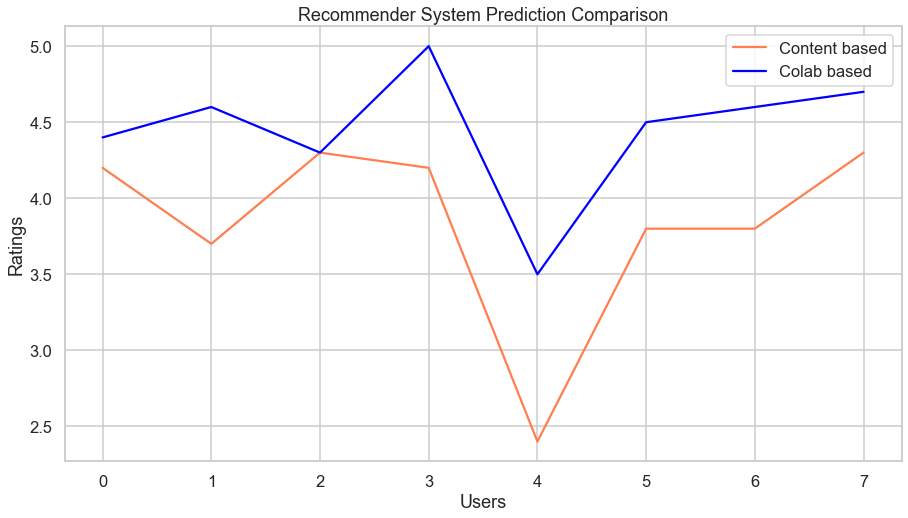

In [ ]:
# Plot comparison

X=range(0,8) # Use range to represent number of users

sns.set(style="whitegrid", context="talk")
f, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(x=X, y="content based ratings", data=user_dataframe,color="coral", label="Content based") # Content based plot
sns.lineplot(x=X, y="collaborative based ratings", data=user_dataframe,color="blue", label="Colab based") # Collaborative based plot
plt.xlabel('Users') 
plt.ylabel('Ratings')
plt.title('Recommender System Prediction Comparison') 

plt.show()

The dataframe below illustrates the difference in movie recommendations for the collaborative and content based models. The movie selected is Double Team and the top 10 recommendations given by the recommenders are shown.

The results of the recommendations are as expected. The content based model uses the similarity features of genres and title cast, which results in recommendations of the same genre or containing the same actors. Jean-Claude Van Damme stars in the first four content recommendations. This makes content based model more rigid if variety is needed.

The collaborative model provides are greater variety of recommendations, since it recommends based off user ratings. This means that popular movies are likely to be recommended. This is true as The Shawshank Redemption is highly rated movie as we as many other titles recommended.

In [130]:
# Recommendation code for each model

recommendations=list(recommendation('Double Team')) # Content system recommendations
recommendation_collab = collab_model1(['Double Team (1997)'],10) # Collaborative system recommendations

In [131]:
recommendation_comparison=pd.DataFrame(data={'content based recommedations':recommendations,
                                             'collaborative based model':recommendation_collab})
recommendation_comparison

,content based recommedations,collaborative based model
0,Maximum Risk,In the Bleak Midwinter (1995)
1,Universal Soldier: Day of Reckoning,While You Were Sleeping (1995)
2,Assassination Games,House Arrest (1996)
3,Knock Off,Inventing the Abbotts (1997)
4,Kung Fu Panda 2,Swimfan (2002)
5,Welcome to the Jungle,"Roommate, The (2011)"
6,Lionheart,Deadly Daycare (2014)
7,Asterix & Obelix vs. Caesar (Astérix et Obélix...,Eddie (1996)
8,Go Figure (Va savoir),Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
9,Street Fighter,Dead Man Walking (1995)


# Tailored movie recommenders
In this section we explore the possibilty of recommending movies based on

- Cast
- Genre
- Keywords
- Director

In [132]:
# create seperate dataframes for each category
cast = df[['title','rating','title_cast']].dropna()
genres = df[['title','rating','genres']].dropna()
keywords = df[['title','rating','plot_keywords']].dropna()
directors = df[['title','rating','director']].dropna()

In [133]:

def recommend(word, df, column_name):
  '''takes in a word, dataframe and column name as argument
    returns a predicted movie list a user will like
  '''
  subset = df[df[column_name].str.contains(word)] 
  # A ratings dataframe can be generated from uniw\que movie titles and their average ratings across all users
  ratings=subset.groupby(['title'])['rating'].mean() #group by title and aggregate ratings
  ratings=pd.DataFrame(ratings)
  ratings=ratings.fillna(2) # fill missing values with generic score of 2 (40%)
  ratings['num of ratings']=df.groupby(['title'])['rating'].count() #generate a column witht the total number of ratings

  content=df.groupby(['title'])[column_name].unique() #group by title and display unique values in a list
  content=pd.DataFrame(content)

  movie_df=pd.merge(ratings,content,on='title') #join on index  

  # Sort move_df from highest to lowest num of ratings
  movie_df=movie_df.sort_values('num of ratings',ascending=False)

  feature=movie_df[[column_name]][0:30000]

  feature.reindex()
  feature = feature.rename(columns={1:'column_name'})

  # Set up vectorizer
  vec=TfidfVectorizer(stop_words='english') # term frequency inverse document frequency

  # Vectorize combined column
  feature_vec=vec.fit_transform(feature)

  # Use cosine similarity to get similarity matrix
  sim_matrix =cosine_similarity(feature_vec,feature_vec)

  # Reset the move_df index as it will be used to generate a Series that will map sim_mat
  movie_df=movie_df.reset_index()

  # Index mapping
  index_map = pd.DataFrame(movie_df.index,index = movie_df['title']) # contains a series of the movie titles in movie_df

  return movie_df['title'][0:10]

In [134]:
word = 'Jonathan Nolan'
print(recommend(word,directors,'director'))

0          Dark Knight, The
1             Prestige, The
2              Interstellar
3    Dark Knight Rises, The
Name: title, dtype: object


In [135]:
word = 'Tom Hanks'
print(recommend(word,cast,'title_cast'))

0            Forrest Gump
1               Toy Story
2               Apollo 13
3     Saving Private Ryan
4         Green Mile, The
5     Catch Me If You Can
6    Sleepless in Seattle
7             Toy Story 2
8               Cast Away
9            Philadelphia
Name: title, dtype: object


In [136]:
word = 'sex scene'
print(recommend(word,keywords,'plot_keywords'))

0    Requiem for a Dream
1    Legends of the Fall
2         Bruce Almighty
3               Election
4                   Troy
5        Specialist, The
6           Analyze This
7       Don Juan DeMarco
8        Double Jeopardy
9               Sunshine
Name: title, dtype: object


In [137]:
word = 'Drama'
print(recommend(word,genres,'genres'))

0                         Shawshank Redemption, The
1                                      Forrest Gump
2                                      Pulp Fiction
3                                  Schindler's List
4                                        Braveheart
5                                        Fight Club
6                                   American Beauty
7                                    Godfather, The
8    Lord of the Rings: The Return of the King, The
9                                     Fugitive, The
Name: title, dtype: object


Sometimes Big Data can miss the human side of making choices. 

One problem arises when you search a keyword 'cowboy', it recommends a movie called "Broke Back Mountain". If your child wanted to watch a cowboy movie then there needs to be a filter put in place to prevent children seeing inappropriate content.

This can be a feature for our app.

The app can make recommendations but also filter the content to be age specific.

# Comet version control

In [ ]:
# Comet logging

params = {"random_state": 'none',
          "model_type": "SVD",
          "scaler": "none",
          "param_grid": str(param_grid)
          }
metrics = {"RMSE": 'none',
           "top n": 'none',
           "MAE": 'none'
           }

# Log parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

# End Experiment# Create dictionaries for comet

params = {"random_state": 'none',
          "model_type": "SVD",
          "scaler": "none",
          "param_grid": str(param_grid)
          }
metrics = {"RMSE": 'none',
           "top n": 'none',
           "MAE": 'none'
           }

# Log parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

# End Experiment